In [19]:
import wbdata
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import logging
import psycopg2
from psycopg2 import sql

In [20]:
logging.basicConfig(filename='etl_log.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [21]:
indicators = {
        'NY.GDP.MKTP.KD': 'GDP',
        'NE.GDI.FTOT.KD': 'Gross_Capital_Formation',
        'SL.TLF.TOTL.IN': 'Total_Employment',}

db_params = {
    'host': '127.0.0.1',
    'database': 'microecon',
    'user': 'postgres',
    'password': '1111',
}

db_name = "GDP_Belarus"

In [22]:
try:
    data = wbdata.get_dataframe(indicators, country='BY')
    logging.info('Data download.')
    
except Exception as e:
    
    logging.error(f'Error process: {str(e)}')

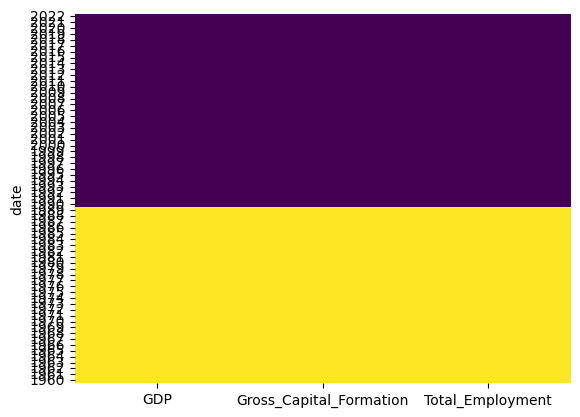

In [23]:
sns.heatmap(data.isnull(),yticklabels=data.index , cmap='viridis', cbar=False,)
plt.show()

In [24]:
data.iloc[:32]

,GDP,Gross_Capital_Formation,Total_Employment
date,,,
2022,5.725185e+10,1.156466e+10,4833522.0
2021,6.007379e+10,1.401072e+10,4892246.0
2020,5.864355e+10,1.489719e+10,4931564.0
2019,5.904084e+10,1.589709e+10,4971033.0
2018,5.819916e+10,1.497561e+10,4998649.0
2017,5.642207e+10,1.459703e+10,5025143.0
2016,5.502894e+10,1.383100e+10,5038419.0
2015,5.645490e+10,1.617670e+10,5042141.0
2014,5.870302e+10,1.913532e+10,5042125.0


In [25]:
data.dtypes

GDP                        float64
Gross_Capital_Formation    float64
Total_Employment           float64
dtype: object

In [34]:
try:
    data = data.iloc[:32]
    data['date'] = data.index.astype(int)
    data_tuples = [tuple(row) for row in data.values]
    logging.info('Data transform.')
    
except Exception as e:
    logging.error(f'Error process: {str(e)}')

In [35]:
create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {db_name} (
        date INTEGER PRIMARY KEY,
        GDP DOUBLE PRECISION,
        Gross_Capital_Formation DOUBLE PRECISION,
        Total_Employment DOUBLE PRECISION
    );
"""

In [36]:
connection = psycopg2.connect(**db_params)
logging.info('Connect to data base.')
cursor = connection.cursor()

In [38]:
try:
    cursor.execute(create_table_query)
    connection.commit()
    logging.info('Create table.')
    
except Exception as e:
    logging.error(f'Error process: {str(e)}')

In [39]:
insert_query = sql.SQL(f"INSERT INTO {db_name} ({', '.join(data.columns)}) VALUES ({', '.join(['%s' for _ in data.columns])})")

In [40]:
try:
    cursor.executemany(insert_query, data_tuples)
    connection.commit()
    logging.info('Add data in BD.')
    
except Exception as e:
    logging.error(f'Error process: {str(e)}')

In [41]:
try:
    cursor.close()
    connection.close()
    logging.info('End.')
    
except Exception as e:
    logging.error(f'Error process: {str(e)}')